In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_preprocessing import timepoint_split, transform_indices, reindex_data, generate_ranks
from evaluation import model_evaluate, topn_recommendations

%config InlineBackend.figure_format = "svg"
plt.rcParams["figure.figsize"] = 10, 6

## MovieLens-1M

In [3]:
# !mkdir data
# !wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip ml-1m.zip -d data

In [4]:
movielens = pd.read_csv("data/ml-1m/ratings.dat", sep="::", names=["userid", "itemid", "rating", "timestamp"], engine="python")

In [5]:
movielens.nunique()

userid         6040
itemid         3706
rating            5
timestamp    458455
dtype: int64

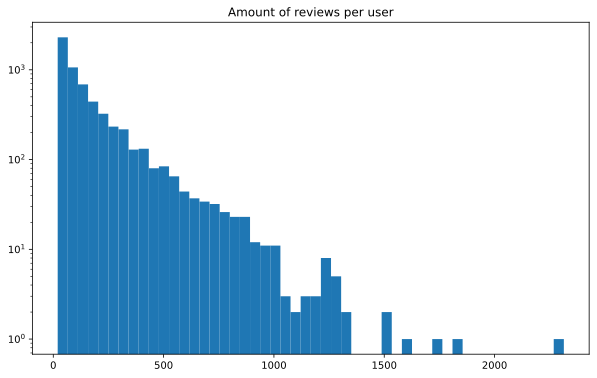

In [6]:
plt.hist(movielens.groupby("userid").size(), bins=50)
plt.yscale("log")
plt.title("Amount of reviews per user")
plt.show()

In [7]:
# Split for final evaluation
_train, _test, _holdout = timepoint_split(movielens, time_split_q=0.95)

len(_train), len(_test), len(_holdout)

(725370, 221697, 802)

In [8]:
# Additional split for hyperparameter tuning
_trainval, _testval, _holdoutval = timepoint_split(_train, time_split_q=0.95)

len(_trainval), len(_testval), len(_holdoutval)

(611093, 77989, 407)

In [9]:
def reindex_all(train, test, holdout=None, userid='userid', itemid='itemid'):
    train_new, data_index = transform_indices(train, userid, itemid)
    test_new = reindex_data(test, data_index, fields='items')
    
    if holdout is None:
        return train_new, test_new, data_index
    
    holdout_new = reindex_data(holdout, data_index, fields='items')
    return train_new, test_new, holdout_new, data_index


trainval, testval, holdoutval, data_index_val = reindex_all(_trainval, _testval, _holdoutval)

In [10]:
data_description = {
    "n_users": trainval.userid.nunique(),
    "n_items": trainval.itemid.nunique(),
    "feedback": "rating",
    "weights": "weights",
    "items": "itemid",
    "users": "userid",
}

trainval = generate_ranks(trainval, data_description)
testval = generate_ranks(testval, data_description)

## Popular

In [11]:
topn = 20

In [12]:
alphas = [2 ** p for p in range(9)]

popular_results = []

for a in alphas:
    def damped_mean(ratings):
        return sum(ratings) / (len(ratings) + a)
    
    item2rating = trainval.groupby('itemid')["rating"].apply(damped_mean)
    best_items = item2rating.nlargest(topn).index.values
    popular_recs = np.ones((len(holdoutval), topn)) * best_items
    metric = model_evaluate(popular_recs, holdoutval, data_description, topn)    
    
    popular_results.append({
        "alpha": a, "metric": metric
    })

popular_results = pd.DataFrame(popular_results)

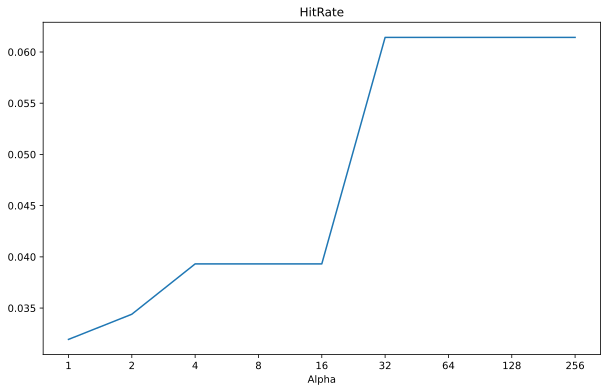

In [13]:
plt.plot(popular_results["alpha"], popular_results["metric"])
plt.xscale("log")
plt.xticks(popular_results["alpha"], popular_results["alpha"])
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("Alpha")

plt.show()

## Pure SVD

In [14]:
from pure_svd import build_svd_model, svd_scoring, svd_gridsearch

In [15]:
ranks = [b * 2 ** p for p in range(0, 7) for b in [2, 3]]
ranks

[2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192]

In [16]:
results = svd_gridsearch(ranks, trainval, testval, holdoutval, data_description, topn)

results = pd.DataFrame(results)

Interaction matrix shape: (4662, 3630)
Matrix density: 0.03611007701916793


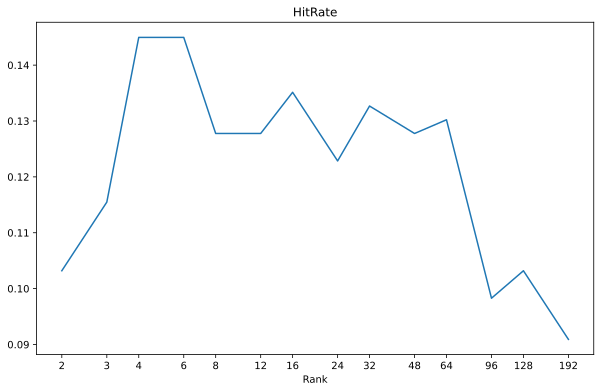

In [17]:
plt.plot(results["rank"], results["metric"])
plt.xscale("log")
plt.xticks(results["rank"], results["rank"])
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("Rank")

plt.show()

In [18]:
best_rank = results.sort_values("metric")["rank"].iloc[-1]
print("Best rank:", best_rank)

model = build_svd_model({"rank": best_rank}, trainval, data_description)
scores = svd_scoring(model, testval, data_description)
svd_recs = topn_recommendations(scores, topn)

Best rank: 6
Interaction matrix shape: (4662, 3630)
Matrix density: 0.03611007701916793


In [19]:
print("HitRate:", model_evaluate(svd_recs, holdoutval, data_description, topn))

HitRate: 0.14496314496314497


## Scaled SVD

In [15]:
from scaled_svd import build_scaled_svd_model, scaled_svd_gridsearch

In [21]:
ranks = [b * 2 ** p for p in range(0, 7) for b in [2, 3]]
ranks

[2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192]

In [22]:
scalings = np.arange(1, 10) / 10
scalings

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [23]:
results = scaled_svd_gridsearch(ranks, scalings, trainval, testval, holdoutval, data_description, topn)

Scaling 0.1
Scaling 0.2
Scaling 0.3
Scaling 0.4
Scaling 0.5
Scaling 0.6
Scaling 0.7
Scaling 0.8
Scaling 0.9


In [24]:
results = pd.DataFrame(results)

results = results.sort_values("metric", ascending=False)

results.head()

,rank,scaling,metric
86,4,0.7,0.154791
100,4,0.8,0.154791
58,4,0.5,0.154791
45,6,0.4,0.152334
72,4,0.6,0.152334


## UserKNN

In [16]:
from knn import uknn_gridsearch, build_uknn_model, uknn_scoring

In [17]:
k_vals = [10, 25, 50, 100, 200, 250, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, None]
p_vals = [0] # np.linspace(0, 1, 21)

config = {
    "similarity_A": "cosine", 
    "similarity_T": None,
}

In [18]:
%%time
results = uknn_gridsearch(k_vals, p_vals, config, trainval, testval, holdoutval, data_description, topn=20)

CPU times: total: 3.61 s
Wall time: 3.67 s


In [19]:
knn_results = pd.DataFrame(results)

knn_results.drop("power", axis=1).sort_values("metric", ascending=False)

,k,metric
7,1000.0,0.066339
8,1500.0,0.066339
6,500.0,0.061425
9,2000.0,0.061425
11,3000.0,0.061425
1,25.0,0.058968
3,100.0,0.058968
5,250.0,0.058968
10,2500.0,0.058968
12,3500.0,0.058968


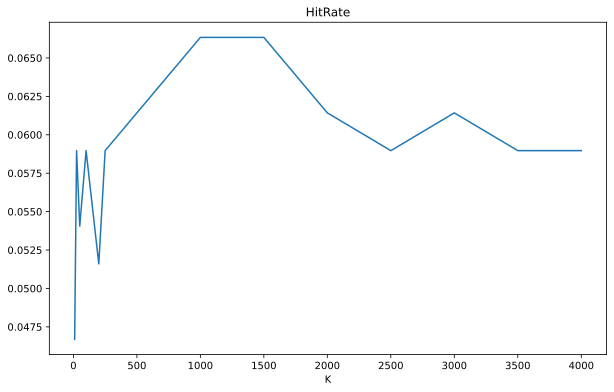

In [20]:
plt.plot(k_vals, knn_results.sort_values("k", na_position="last")["metric"])

plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("K")

plt.show()

## SeqUserKNN

In [21]:
%%time
k_vals = [10, 25, 50, 100, 200, 250, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, None]
p_vals = np.linspace(0, 1, 21)

config = {
    "similarity_A": "cosine", 
    "similarity_T": "cosine",
}

results = uknn_gridsearch(k_vals, p_vals, config, trainval, testval, holdoutval, data_description, topn)

CPU times: total: 1min 39s
Wall time: 1min 40s


In [41]:
seq_knn_results = pd.DataFrame(results)
seq_knn_results.sort_values('metric', ascending=False).head()

,power,k,metric
278,0.90,1500.0,0.076167
287,0.95,50.0,0.076167
307,1.00,1000.0,0.076167
302,1.00,50.0,0.076167
113,0.35,1500.0,0.073710


In [42]:
seq_knn_results.pivot(index="power", columns="k", values="metric").style.format("{:.5f}").background_gradient(high=0.3, axis = None)


k,nan,10.000000,25.000000,50.000000,100.000000,200.000000,250.000000,500.000000,1000.000000,1500.000000,2000.000000,2500.000000,3000.000000,3500.000000,4000.000000
power,,,,,,,,,,,,,,,
0.000000,0.063882,0.05160,0.04914,0.05160,0.06143,0.05651,0.05651,0.06143,0.06143,0.07125,0.06880,0.06634,0.06388,0.06388,0.06388
0.050000,0.063882,0.05160,0.05160,0.05160,0.05651,0.05651,0.05897,0.06143,0.06143,0.07125,0.06880,0.06634,0.06388,0.06388,0.06388
0.100000,0.063882,0.04914,0.05405,0.05405,0.05651,0.05651,0.05651,0.06143,0.06143,0.07125,0.06880,0.06634,0.06388,0.06388,0.06388
0.150000,0.063882,0.05160,0.05897,0.05897,0.05651,0.05651,0.05651,0.06634,0.06388,0.07125,0.06880,0.06634,0.06388,0.06388,0.06388
0.200000,0.066339,0.05160,0.05651,0.05897,0.05651,0.06388,0.05897,0.06634,0.06634,0.07125,0.06880,0.06634,0.06634,0.06634,0.06634
0.250000,0.066339,0.05897,0.05160,0.06143,0.06143,0.06634,0.05897,0.06634,0.06634,0.07125,0.06880,0.06634,0.06634,0.06634,0.06634
0.300000,0.066339,0.05160,0.04914,0.05897,0.06143,0.06634,0.06388,0.06143,0.06880,0.07125,0.06880,0.06634,0.06634,0.06634,0.06634
0.350000,0.066339,0.04668,0.05405,0.05405,0.05897,0.06388,0.06143,0.05897,0.06880,0.07371,0.06880,0.06634,0.06634,0.06634,0.06634
0.400000,0.066339,0.05160,0.05897,0.05897,0.05897,0.06634,0.05897,0.06143,0.06634,0.07371,0.06880,0.06634,0.06634,0.06634,0.06634


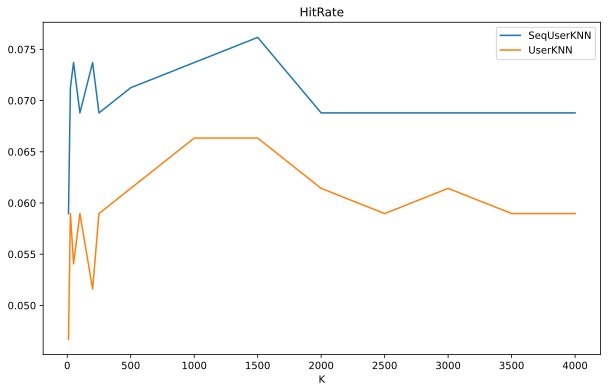

In [43]:
plt.plot(k_vals, seq_knn_results[lambda x: np.isclose(x["power"], 0.9)]["metric"], label="SeqUserKNN")
plt.plot(k_vals, knn_results["metric"], label="UserKNN")
plt.tick_params(which="minor", size=0)
plt.title("HitRate")
plt.xlabel("K")
plt.legend()

plt.show()

## Jaccard

In [71]:
from jaccard_svd import build_jaccard_svd_model

ModuleNotFoundError: No module named 'jaccard_svd'

In [47]:
%%time
# csc_matrix

config = dict(
    rank=64,
    jaccard_coef=0.5
)

model = build_jaccard_svd_model(config, trainval, data_description)

d:\Skoltech\Intro to Recommender Systems\sequence-aware-similarity-for-recommendations\jaccard_svd.py:18: RuntimeWarning: invalid value encountered in divide
  similarity[:, u] = (repeated_row_matrix.minimum(matrix_B).sum(axis=1) / repeated_row_matrix.maximum(matrix_B).sum(axis=1))


KeyboardInterrupt: 

In [34]:
%%time
# csr_matrix + csc_matrix

config = dict(
    rank=64,
    jaccard_coef=0.5
)

model = build_jaccard_svd_model(config, trainval, data_description)

CPU times: user 1min 33s, sys: 1.36 s, total: 1min 35s
Wall time: 1min 34s


In [35]:
%%time
# csr_matrix + _

config = dict(
    rank=64,
    jaccard_coef=0.5
)

model = build_jaccard_svd_model(config, trainval, data_description)

CPU times: user 1min 31s, sys: 1.19 s, total: 1min 32s
Wall time: 1min 31s


In [36]:
from jaccard_svd import jaccard_svd_gridsearch

ranks = [b * 2 ** p for p in range(0, 7) for b in [2, 3]]
ranks

[2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192]

In [37]:
coefs = np.arange(1, 10, 2) / 10
coefs

array([0.1, 0.3, 0.5, 0.7, 0.9])

In [39]:
jaccard_results = jaccard_svd_gridsearch(ranks, coefs, trainval, testval, holdoutval, data_description, topn)

0.1
0.3
0.5
0.7
0.9


In [40]:
jaccard_results = pd.DataFrame(jaccard_results)

jaccard_results = jaccard_results.sort_values("metric", ascending=False)

jaccard_results

,rank,metric,jaccard_coef
45,6,0.157248,0.7
2,4,0.147420,0.1
31,6,0.147420,0.5
17,6,0.147420,0.3
60,8,0.147420,0.9
...,...,...,...
28,2,0.078624,0.5
43,3,0.054054,0.7
57,3,0.041769,0.9
42,2,0.039312,0.7


In [54]:
jaccard_results.head()

,rank,metric,jaccard_coef
45,6,0.157248,0.7
2,4,0.147420,0.1
31,6,0.147420,0.5
17,6,0.147420,0.3
60,8,0.147420,0.9


## Final Eval

In [22]:
train, test, holdout, data_index = reindex_all(_train, _test, _holdout)

In [23]:
data_description = {
    "n_users": train.userid.nunique(),
    "n_items": train.itemid.nunique(),
    "feedback": "rating",
    "weights": "weights",
    "items": "itemid",
    "users": "userid",
}

train = generate_ranks(train, data_description)
test = generate_ranks(test, data_description)

In [24]:
grand_total = []

In [25]:
def damped_mean(ratings):
    return sum(ratings) / (len(ratings) + 256)

item2rating = train.groupby('itemid')["rating"].apply(damped_mean)
best_items = item2rating.nlargest(topn).index.values
popular_recs = np.ones((len(holdout), topn)) * best_items
metric = model_evaluate(popular_recs, holdout, data_description, topn)    

grand_total.append(
    {"method": "popularity", "metric": metric}
)

In [26]:
best_rank = 6
print("Best rank:", best_rank)

model = build_svd_model({"rank": best_rank}, train, data_description)
scores = svd_scoring(model, test, data_description)
svd_recs = topn_recommendations(scores, topn)

metric = model_evaluate(svd_recs, holdout, data_description, topn)

grand_total.append(
    {"method": "PureSVD", "metric": metric}
)

Best rank: 6
Interaction matrix shape: (5227, 3652)
Matrix density: 0.03799936340314036


In [27]:
best_config = {
    "rank": 4, "scaling": 0.7,
}
print(best_config)

model = build_scaled_svd_model(best_config, train, data_description)
scores = svd_scoring(model, test, data_description)
svd_recs = topn_recommendations(scores, topn)

metric = model_evaluate(svd_recs, holdout, data_description, topn)

grand_total.append(
    {"method": "ScaledSVD", "metric": metric}
)

{'rank': 4, 'scaling': 0.7}


In [78]:
best_config = {
    "rank": 6, "jaccard_coef": 0.7,
}
print(best_config)

model = build_jaccard_svd_model(best_config, train, data_description)
scores = svd_scoring(model, test, data_description)
svd_recs = topn_recommendations(scores, topn)

metric = model_evaluate(svd_recs, holdout, data_description, topn)

grand_total.append(
    {"method": "JaccardSVD", "metric": metric}
)

{'rank': 6, 'jaccard_coef': 0.7}


NameError: name 'build_jaccard_svd_model' is not defined

In [28]:
best_config = {
    "power": 0,
    "k": 1000,
    "similarity_A": "cosine",
    "similarity_T": None
}

model = build_uknn_model(best_config, train, data_description)
scores = uknn_scoring(model, test, data_description)
uknn_recs = topn_recommendations(scores, topn)

metric = model_evaluate(uknn_recs, holdout, data_description, topn)

grand_total.append(
    {"method": "UserKNN", "metric": metric}
)

In [29]:
best_config = {
    "power": 0.9,
    "k": 1500,
    "similarity_A": "cosine",
    "similarity_T": "cosine"
}

model = build_uknn_model(best_config, train, data_description)
scores = uknn_scoring(model, test, data_description)
seq_uknn_recs = topn_recommendations(scores, topn)

metric = model_evaluate(seq_uknn_recs, holdout, data_description, topn)

grand_total.append(
    {"method": "SeqUserKNN", "metric": metric}
)

In [31]:
pd.DataFrame(grand_total).sort_values("metric", ascending=False)

,method,metric
4,SeqUserKNN,0.118454
3,UserKNN,0.114713
2,ScaledSVD,0.099751
1,PureSVD,0.094763
0,popularity,0.056110
